In [1]:
!pip -q install yfinance numpy pandas matplotlib statsmodels scipy

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import binomtest, skew, kurtosis, entropy
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf

import yfinance as yf, os, math, textwrap
plt.rcParams["figure.figsize"] = (12, 5)
os.makedirs("docs/charts", exist_ok=True)

def save_fig(name): plt.savefig(f"docs/charts/{name}.png", dpi=300, bbox_inches="tight")

/tmp/ipython-input-3908717659.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(TICKER, start=START, end=END)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed


Ticker      EURUSD=X
Date                
2024-12-27  1.042318
2024-12-30  1.042938
2024-12-31  1.040615
Obs: 3907 Up rate: 0.4948


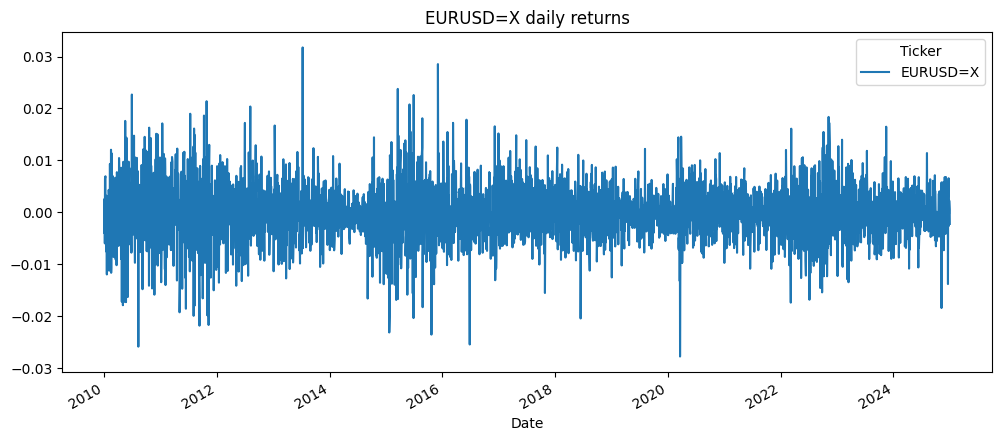

In [2]:
TICKER = "EURUSD=X"
START, END = "2010-01-01", "2025-01-01"

px = yf.download(TICKER, start=START, end=END)["Close"].dropna()
ret = px.pct_change().dropna()
sign = np.where(ret > 0, 1, 0)

print(px.tail(3))
print("Obs:", len(ret), "Up rate:", sign.mean().round(4))
ret.plot(title=f"{TICKER} daily returns"); save_fig("eurusd_returns"); plt.show()

In [3]:
n = len(sign)
k = sign.sum()
res = binomtest(k, n, p=0.5, alternative="two-sided")
print(f"Up days: {k}/{n} = {k/n:.4}, p-value={res.pvalue:.4g}")

Up days: 1933/3907 = 0.4948, p-value=0.5222


In [4]:
def count_runs(seq):
  runs, last = 1, seq[0]
  for s in seq[1:]:
    if s != last:
      runs += 1
      last = s
  return runs

def wald_wolfowitz_runs_test(seq):
  seq = np.asarray(seq)
  n1, n2 = seq.sum(), len(seq)-seq.sum()
  R = count_runs(seq)
  mu = 1 + 2 * n1 * n2 / (n1 + n2)
  var = (2 * n1 * n2 * (2 * n1 * n2 - n1 - n2))/(((n1 + n2) ** 2) * (n1 + n2 - 1))
  z = (R - mu)/math.sqrt(var) if var > 0 else np.nan

  from scipy.stats import norm
  p = 2 * (1 - norm.cdf(abs(z)))
  return dict(R=R, E_mu=mu, Var=var, z=z, pvalue=p, n1=int(n1), n2=int(n2))

runs_res = wald_wolfowitz_runs_test(sign)
runs_res

{'R': 1984,
 'E_mu': np.float64(1954.2848733043256),
 'Var': np.float64(976.2848211485384),
 'z': np.float64(0.9510192717791287),
 'pvalue': np.float64(0.34159459292114613),
 'n1': 1933,
 'n2': 1974}

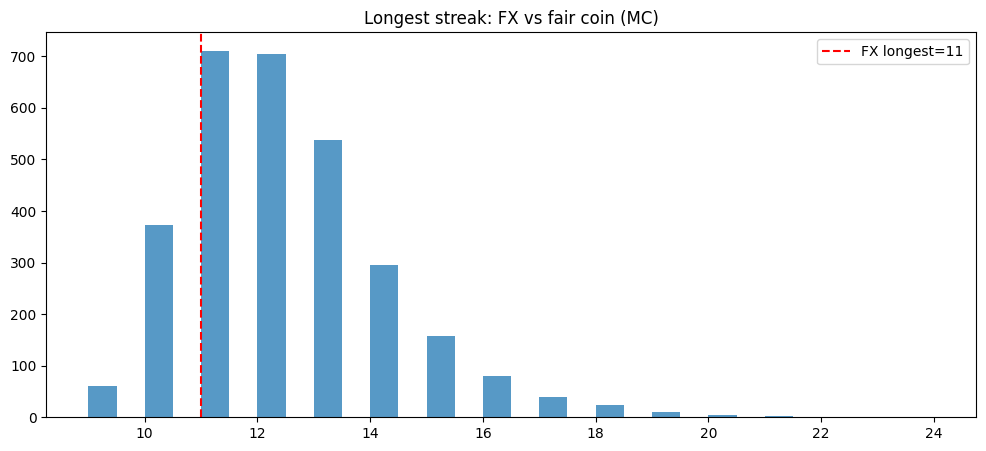

FX longest run=11, MC p-value=0.8560


In [5]:
def run_lengths(seq):
  out, cur = [], 1
  for i in range(1, len(seq)):
    if seq[i] == seq[i - 1]: cur += 1
    else: out.append(cur); cur=1
  out.append(cur); return out

fx_longest = max(run_lengths(sign))

def sim_longest_run(n, trials=2000):
  L = np.empty(trials, dtype=int)
  for t in range(trials):
    seq = np.random.randint(0, 2, size=n)
    L[t] = max(run_lengths(seq))
  return L

simL = sim_longest_run(len(sign), trials=3000)
plt.hist(simL, bins=30, alpha=0.75)
plt.axvline(fx_longest, color="r", ls="--", label=f"FX longest={fx_longest}")
plt.title("Longest streak: FX vs fair coin (MC)"); plt.legend(); save_fig("longest_streaks"); plt.show()

p_mc = (simL >= fx_longest).mean()
print(f"FX longest run={fx_longest}, MC p-value={p_mc:.4f}")

P(up|up) = 0.4893
P(up|down) = 0.5023
p(up|up vs .5) = 0.2554  p(up|down vs .5) = 0.8571


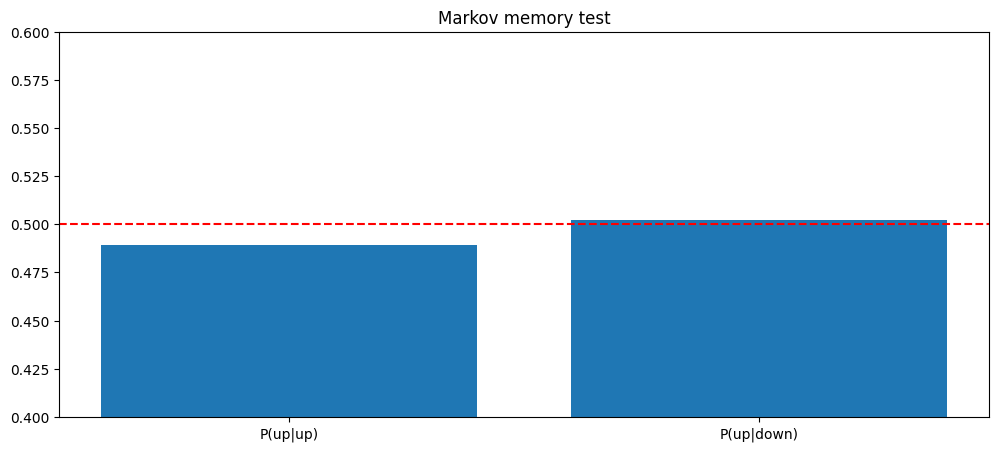

In [6]:
uu = ud = du = dd= 0
for a, b in zip(sign[:-1], sign[1:]):
  if a==1 and b==1: uu+=1
  if a==1 and b==0: ud+=1
  if a==0 and b==1: du+=1
  if a==0 and b==0: dd+=1

P_up_after_up = uu / (uu + dd)
P_up_after_down = du / (du + dd)

print("P(up|up) =", round(P_up_after_up, 4))
print("P(up|down) =", round(P_up_after_down, 4))

p1 = binomtest(uu, uu+ud, 0.5).pvalue
p2 = binomtest(du, du+dd, 0.5).pvalue
print("p(up|up vs .5) =", round(p1, 4), " p(up|down vs .5) =", round(p2, 4))

plt.bar(["P(up|up)", "P(up|down)"], [P_up_after_up, P_up_after_down])
plt.axhline(0.5, color="r", ls="--"); plt.ylim(0.4, 0.6)
plt.title("Markov memory test"); save_fig("markov_memory"); plt.show()

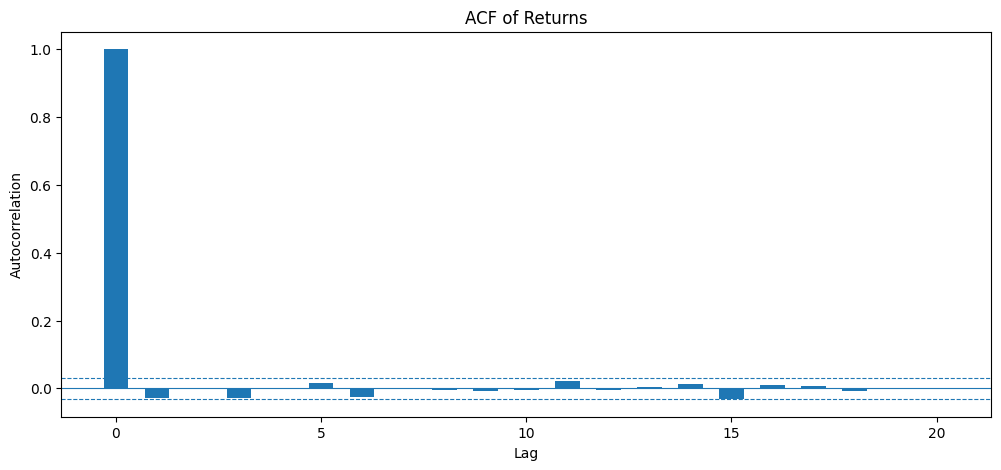

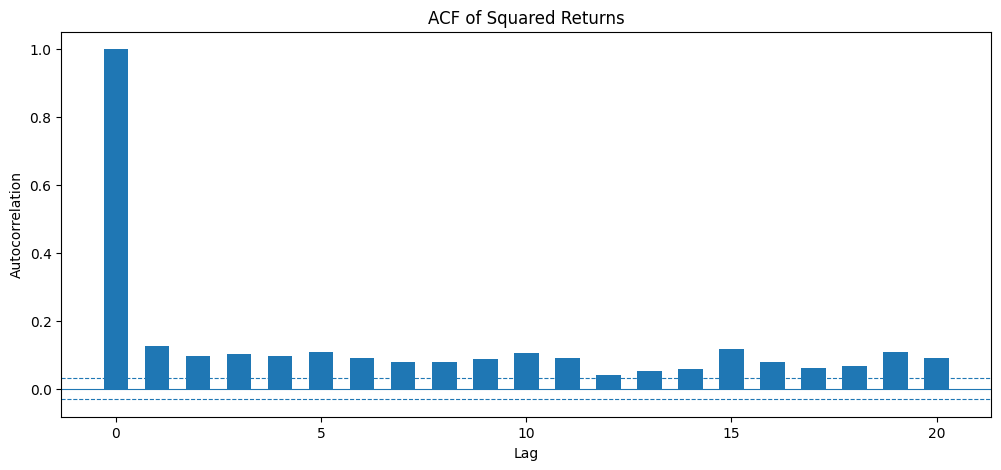

Ljung–Box (returns):
   lb_stat  lb_pvalue
10.792768   0.373890
18.153955   0.577267

Ljung–Box (squared returns):
    lb_stat     lb_pvalue
374.325016  2.718635e-74
620.526069 1.358391e-118


In [7]:
from math import sqrt

lags = 20

acf_r = acf(ret, fft=True, nlags=lags)
acf_r2 = acf(ret**2, fft=True, nlags=lags)

N = len(ret)
conf = 1.96 / sqrt(N)

def plot_acf(vals, title, fname):
  plt.figure()
  plt.bar(range(lags + 1), vals, width=0.6)
  plt.axhline(0, linewidth=0.8)
  plt.axhline(+conf, linewidth=0.8, linestyle="--")
  plt.axhline(-conf, linewidth=0.8, linestyle="--")
  plt.title(title); plt.xlabel("Lag"); plt.ylabel("Autocorrelation")
  save_fig(fname); plt.show()

plot_acf(acf_r, "ACF of Returns", "acf_returns")
plot_acf(acf_r2, "ACF of Squared Returns", "acf_returns_squared")

lb_r = acorr_ljungbox(ret, lags=[10, 20], return_df=True)
lb_r2 = acorr_ljungbox(ret**2, lags=[10, 20], return_df=True)

print("Ljung–Box (returns):\n",  lb_r.to_string(index=False))
print("\nLjung–Box (squared returns):\n", lb_r2.to_string(index=False))

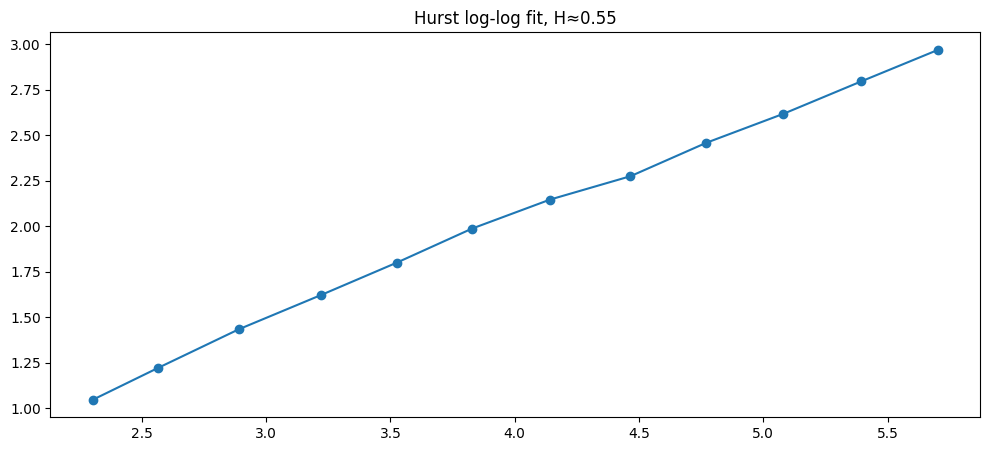

Hurst exponent ≈ 0.554


In [8]:
def hurst_rs(x, min_win=10, max_win=300):
  x = np.asarray(x); N = len(x)
  wins = np.unique(np.logspace(np.log10(min_win), np.log10(max_win), 12). astype(int))
  RS, n = [], []
  for w in wins:
    if w * 5 > N: break
    m = N // w
    segs = x[:m * w].reshape(m, w)
    r_s_vals = []
    for seg in segs:
      Y = seg - seg.mean()
      Z = np.cumsum(Y)
      R = Z.max() - Z.min()
      S = seg.std(ddof=1)
      if S > 0: r_s_vals.append(R/S)
    if len(r_s_vals) > 0:
      RS.append(np.mean(r_s_vals)); n.append(w)
  n, RS = np.array(n), np.array(RS)
  H = np.polyfit(np.log(n), np.log(RS), 1)[0]
  return H, n, RS

H, n, RS = hurst_rs(ret.values)
plt.plot(np.log(n), np.log(RS), "o-"); plt.title(f"Hurst log-log fit, H≈{H:.2f}")
save_fig("hurst_fit"); plt.show()
print("Hurst exponent ≈", round(H, 3))

In [9]:
p_up = sign.mean()
p_down = 1 - p_up
probs = [p for p in [p_up, p_down] if p > 0]
H_bits = -sum(p * np.log2(p) for p in probs)
print(f"Shannon entropy (bits) ≈ {H_bits:.3f} (max is 1 for fair coin)")

Shannon entropy (bits) ≈ 1.000 (max is 1 for fair coin)


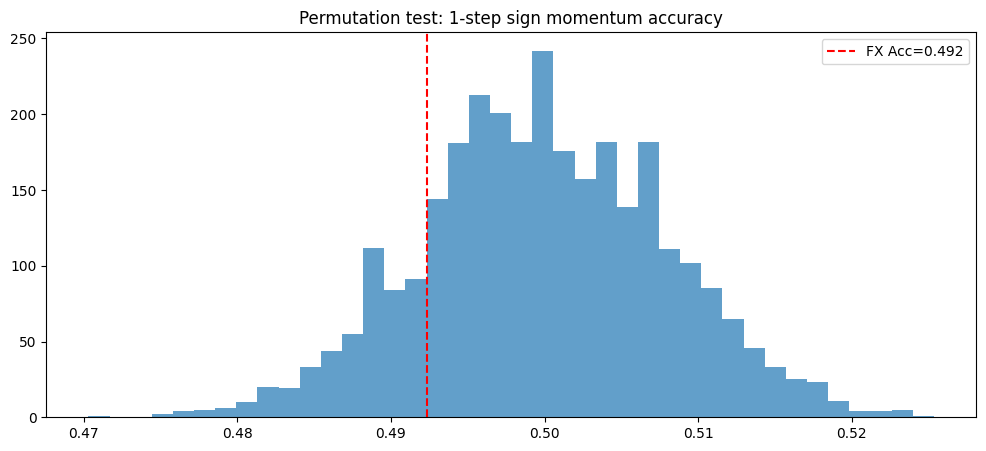

FX accuracy=0.492, permutation p≈0.8380


In [10]:
sign = np.asarray(sign).ravel().astype(int)

def acc_one_step(seq):
  seq = np.asarray(seq).ravel()
  return np.mean(seq[1:] == seq[:-1])

acc_fx = acc_one_step(sign)

def perm_test_accuracy(seq, trials=2000):
  seq = np.asarray(seq).ravel()
  acc = np.empty(trials)
  for t in range(trials):
    s = np.random.permutation(seq)
    acc[t] = acc_one_step(s)
  return acc

acc_sim = perm_test_accuracy(sign, 3000)

plt.hist(acc_sim, bins=40, alpha=0.7)
plt.axvline(acc_fx, color="r", ls="--", label=f"FX Acc={acc_fx:.3f}")
plt.legend(); plt.title("Permutation test: 1-step sign momentum accuracy")
save_fig("perm_test_momentum"); plt.show()

p_perm = (acc_sim >= acc_fx).mean()
print(f"FX accuracy={acc_fx:.3f}, permutation p≈{p_perm:.4f}")